In [4]:
import torch
import torch_directml
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from torchvision.transforms import v2
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from model import mobilevig
from PIL import Image

In [5]:
device = torch_directml.device()
model = mobilevig.mobilevig_ti().to(device)

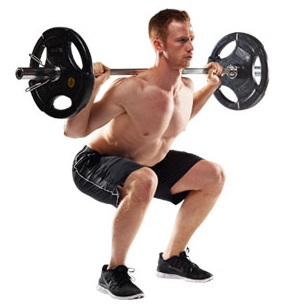

In [6]:
image = Image.open("./dataset/Squat/squat_23.jpg")

image

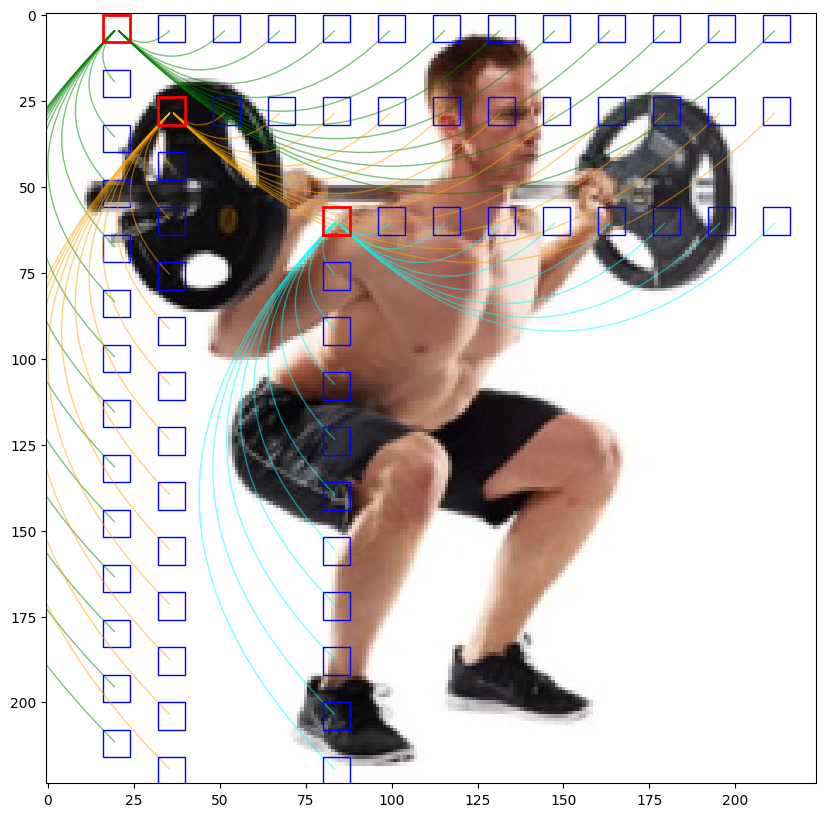

In [7]:
# Visualize MobileViG Architecture
def visualize_svga_graph(image, patch_size, k, node_indices):
    # Convert image tensor to numpy array
    image_np = image.cpu().squeeze().permute(1, 2, 0).numpy()
    # Plot the image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_np)
    img_height, img_width, _ = image_np.shape
    num_patches_row = img_width // patch_size
    num_patches_col = img_height // patch_size

    # Create a custom colormap excluding red
    colors = [
        "green",
        "yellow",
        "orange",
        "cyan",
    ]
    n_bins = len(colors)
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)
    # Generate distinct colors for edges of each node
    edge_colors = [cmap(i) for i in np.linspace(0, 1, len(node_indices))]

    for idx, node_index in enumerate(node_indices):
        # Get the coordinates of the main node
        main_x, main_y = patch_index_to_coords(node_index, patch_size, img_width)
        edge_color = edge_colors[idx]

        # Draw connections to every kth pixel in the row and column
        for offset in range(k, max(num_patches_row, num_patches_col), k):
            # Right row connection
            if (node_index % num_patches_row) + offset < num_patches_row:
                connected_index = node_index + offset
                nx, ny = patch_index_to_coords(connected_index, patch_size, img_width)
                # Draw line
                connection = patches.FancyArrowPatch(
                    (main_y + patch_size / 2, main_x + patch_size / 2),
                    (ny + patch_size / 2, nx + patch_size / 2),
                    connectionstyle="arc3,rad=.5",
                    color=edge_color,
                    alpha=0.5,
                    arrowstyle="-",
                )
                ax.add_patch(connection)
                # Draw connected node in blue
                connected_rect = Rectangle(
                    (ny, nx),
                    patch_size,
                    patch_size,
                    linewidth=1,
                    edgecolor="blue",
                    facecolor="none",
                )
                ax.add_patch(connected_rect)

            # Down column connection
            if (node_index // num_patches_row) + offset < num_patches_col:
                connected_index = node_index + (offset * num_patches_row)
                nx, ny = patch_index_to_coords(connected_index, patch_size, img_width)
                # Draw line
                connection = patches.FancyArrowPatch(
                    (main_y + patch_size / 2, main_x + patch_size / 2),
                    (ny + patch_size / 2, nx + patch_size / 2),
                    connectionstyle="arc3,rad=.5",
                    color=edge_color,
                    alpha=0.5,
                    arrowstyle="-",
                )
                ax.add_patch(connection)
                # Draw connected node in blue
                connected_rect = Rectangle(
                    (ny, nx),
                    patch_size,
                    patch_size,
                    linewidth=1,
                    edgecolor="blue",
                    facecolor="none",
                )
                ax.add_patch(connected_rect)

        # Draw the main node in red
        main_rect = Rectangle(
            (main_y, main_x),
            patch_size,
            patch_size,
            linewidth=2,
            edgecolor="red",
            facecolor="none",
        )
        ax.add_patch(main_rect)

    plt.show()

# Helper function to convert patch index to coordinates
def patch_index_to_coords(index, patch_size, img_width):
    num_patches_per_row = img_width // patch_size
    row = index // num_patches_per_row
    col = index % num_patches_per_row
    return row * patch_size, col * patch_size

# Preprocess the image
preprocess = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224)),  # Resize to 224x224
        v2.ToDtype(torch.float32, scale=True),
    ]
)
image_tensor = preprocess(image).unsqueeze(dim=0).to(device)

# Parameters
patch_size = 8  # Example patch size
k = 2  # Number of connections for SVGA graph
node_indices = [2, 88, 206]  # Example node indices to visualize

# Visualize the nodes with their SVGA connections
visualize_svga_graph(image_tensor, patch_size, k, node_indices)